In [2]:
import os
import os.path as op
import nibabel as nib
import numpy as np
import csv
from sklearn.metrics import f1_score, jaccard_score, precision_recall_fscore_support
from sklearn.utils import resample
from nilearn import maskers
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
deriv_dir = "./derivatives"
aub_dir = "./data/aub"
hcp_dir = "./data/hcp-resampled"
roi_dir = op.join(deriv_dir, "avg-masks")
stat_dir = op.join(deriv_dir, "stats")


if not op.exists(stat_dir):
    os.makedirs(stat_dir)

## Data
let's load the data in a way that we can calculate scores

In [57]:
aub = op.join(roi_dir, "aub_hb_avg.nii.gz")
hcp = op.join(roi_dir, "hcp_hb_avg_resample.nii.gz")

aub_nii_image = nib.load(aub)
aub_nii_data = aub_nii_image.get_fdata()
# make binary
aub_nii_data = np.where(aub_nii_data > 0, 1, 0)

hcp_nii_image = nib.load(hcp)
hcp_nii_data = hcp_nii_image.get_fdata()
hcp_nii_data = np.where(hcp_nii_data > 0, 1, 0)


# Ensure both arrays have the same shape
if hcp_nii_data.shape == aub_nii_data.shape:
    # Flatten the arrays for F1 score calculation
    hcp_flat = hcp_nii_data.flatten()
    aub_flat = aub_nii_data.flatten()

In [39]:
dil_aub = op.join(roi_dir, "aub_dil-hb_avg.nii.gz")
dil_hcp = op.join(roi_dir, "hcp_dil-hb_avg_resample.nii.gz")

aub_nii_image = nib.load(dil_aub)
aub_nii_data = aub_nii_image.get_fdata()
# make binary
aub_nii_data = np.where(aub_nii_data > 0, 1, 0)

hcp_nii_image = nib.load(dil_hcp)
hcp_nii_data = hcp_nii_image.get_fdata()
hcp_nii_data = np.where(hcp_nii_data > 0, 1, 0)


# Ensure both arrays have the same shape
if hcp_nii_data.shape == aub_nii_data.shape:
    # Flatten the arrays for F1 score calculation
    dil_hcp_flat = hcp_nii_data.flatten()
    dil_aub_flat = aub_nii_data.flatten()

## Weights

In [12]:
from sklearn.utils.class_weight import compute_class_weight

hpc_weight = compute_class_weight(class_weight="balanced", classes=np.unique(hcp_flat), y=hcp_flat)
aub_weight = compute_class_weight(class_weight="balanced", classes=np.unique(aub_flat), y=aub_flat)
print(hpc_weight, aub_weight)

[5.00079226e-01 3.15604545e+03] [5.00108595e-01 2.30262500e+03]


## F1 Scores

In [58]:
averages = ["binary", "macro", "weighted"]

for average in averages:
    f1 = f1_score(hcp_flat, aub_flat, average = average)
    print(f"{average} F1 Score between hcp and aub:", f1)


f1_score(hcp_flat, aub_flat, average=None)

binary F1 Score between hcp and aub: 0.471976401179941
macro F1 Score between hcp and aub: 0.735938613877215
weighted F1 Score between hcp and aub: 0.9998171895621268


array([0.99990083, 0.4719764 ])

In [59]:
for average in averages:
    f1 = f1_score(dil_hcp_flat, dil_aub_flat, average=average)
    print(f"{average} F1 Score between dilated hcp and aub:", f1)

binary F1 Score between dilated hcp and aub: 0.5762237762237762
macro F1 Score between dilated hcp and aub: 0.7880279333377431
weighted F1 Score between dilated hcp and aub: 0.999677689102561


In [62]:
# each aub particpant
results = []

for average in averages:
    for i in range(1, 35):
        subject = f"HIP{i:03}"
        file_to_check = op.join(aub_dir, f"{subject}_hbmask.nii.gz")

        if op.isfile(file_to_check):
            aub_nii_image = nib.load(file_to_check)
            aub_nii_data = aub_nii_image.get_fdata()

            # Ensure both arrays have the same shape
            if hcp_nii_data.shape == aub_nii_data.shape:
                aub_flat = aub_nii_data.flatten()

                # Calculate the F1 score
                f1 = f1_score(hcp_flat, aub_flat, average= average)
                print(f"F1 Score: {f1}")

                # Store the results in a list
                results.append(
                    {"Subject": subject, "Average Type": average, "F1 Score": f1}
                )

            else:
                print(
                    f"{subject} hape mismatch: HCP shape {hcp_nii_data.shape}, AUB shape {aub_nii_data.shape}"
                )

        else:
            print(f"File not found in for {subject}")

f1_df = pd.DataFrame(results)

F1 Score: 0.2441860465116279
F1 Score: 0.08
F1 Score: 0.3389830508474576
F1 Score: 0.07228915662650602
F1 Score: 0.10714285714285714
F1 Score: 0.10126582278481013
F1 Score: 0.0
F1 Score: 0.0
F1 Score: 0.3076923076923077
File not found in for HIP010
F1 Score: 0.2331288343558282
File not found in for HIP012
F1 Score: 0.2958579881656805
F1 Score: 0.3352601156069364
F1 Score: 0.23030303030303031
F1 Score: 0.3176470588235294
F1 Score: 0.08695652173913043
F1 Score: 0.30057803468208094
File not found in for HIP019
File not found in for HIP020
F1 Score: 0.29411764705882354
F1 Score: 0.2235294117647059
F1 Score: 0.2
F1 Score: 0.27380952380952384
F1 Score: 0.32748538011695905
File not found in for HIP026
F1 Score: 0.1893491124260355
File not found in for HIP028
File not found in for HIP029
F1 Score: 0.0625
F1 Score: 0.0
File not found in for HIP032
F1 Score: 0.2236024844720497
F1 Score: 0.1951219512195122
F1 Score: 0.6220570138911632
F1 Score: 0.5399554037127379
F1 Score: 0.6694591169057731
F1 S

In [47]:
# each aub particpant
results = []

for average in averages:
    for i in range(1, 35):
        subject = f"HIP{i:03}"
        file_to_check = op.join(aub_dir, f"{subject}_hbmask.nii.gz")

        if op.isfile(file_to_check):
            aub_nii_image = nib.load(file_to_check)
            aub_nii_data = aub_nii_image.get_fdata()

            # Ensure both arrays have the same shape
            if hcp_nii_data.shape == aub_nii_data.shape:
                aub_flat = aub_nii_data.flatten()

                # Calculate the F1 score
                f1 = f1_score(dil_hcp_flat, aub_flat, average=average)
                print(f"F1 Score: {f1}")

                # Store the results in a list
                results.append(
                    {"Subject": subject, "Average Type": average, "F1 Score": f1}
                )

            else:
                print(
                    f"{subject} hape mismatch: HCP shape {hcp_nii_data.shape}, AUB shape {aub_nii_data.shape}"
                )

        else:
            print(f"File not found in for {subject}")

f1_dildf = pd.DataFrame(results)

F1 Score: 0.15083798882681565
F1 Score: 0.10526315789473684
F1 Score: 0.18732782369146006
F1 Score: 0.09659090909090909
F1 Score: 0.12994350282485875
F1 Score: 0.08139534883720931
F1 Score: 0.023121387283236993
F1 Score: 0.022988505747126436
F1 Score: 0.3046683046683047
File not found in for HIP010
F1 Score: 0.11461318051575932
File not found in for HIP012
F1 Score: 0.14647887323943662
F1 Score: 0.1671309192200557
F1 Score: 0.12535612535612536
F1 Score: 0.15168539325842698
F1 Score: 0.07492795389048991
F1 Score: 0.1671309192200557
File not found in for HIP019
File not found in for HIP020
F1 Score: 0.15168539325842698
F1 Score: 0.14606741573033707
F1 Score: 0.09826589595375723
F1 Score: 0.14124293785310735
F1 Score: 0.1568627450980392
File not found in for HIP026
F1 Score: 0.1352112676056338
File not found in for HIP028
File not found in for HIP029
F1 Score: 0.08092485549132948
F1 Score: 0.04519774011299435
File not found in for HIP032
F1 Score: 0.1037463976945245
F1 Score: 0.12
F1 Scor

In [41]:

# Merge the DataFrames on the "Subject" column using an outer op.join
combined_df = pd.merge(f1_df, f1_dildf, on="subject", how="outer")

# Print the combined DataFrame to ensure it is correct
print(combined_df)

    subject average_type_x  f1_score_x average_type_y  f1_score_y
0    HIP001         binary    0.244186         binary    0.150838
1    HIP001         binary    0.244186          macro    0.575335
2    HIP001         binary    0.244186       weighted    0.999522
3    HIP001          macro    0.622057         binary    0.150838
4    HIP001          macro    0.622057          macro    0.575335
..      ...            ...         ...            ...         ...
229  HIP034          macro    0.597524          macro    0.559915
230  HIP034          macro    0.597524       weighted    0.999509
231  HIP034       weighted    0.999799         binary    0.120000
232  HIP034       weighted    0.999799          macro    0.559915
233  HIP034       weighted    0.999799       weighted    0.999509

[234 rows x 5 columns]


In [45]:

print(f1_df)

   Subject Average Type  F1 Scoree
0   HIP001       binary   0.150838
1   HIP002       binary   0.105263
2   HIP003       binary   0.187328
3   HIP004       binary   0.096591
4   HIP005       binary   0.129944
..     ...          ...        ...
73  HIP027     weighted   0.999515
74  HIP030     weighted   0.999489
75  HIP031     weighted   0.999465
76  HIP033     weighted   0.999501
77  HIP034     weighted   0.999509

[78 rows x 3 columns]


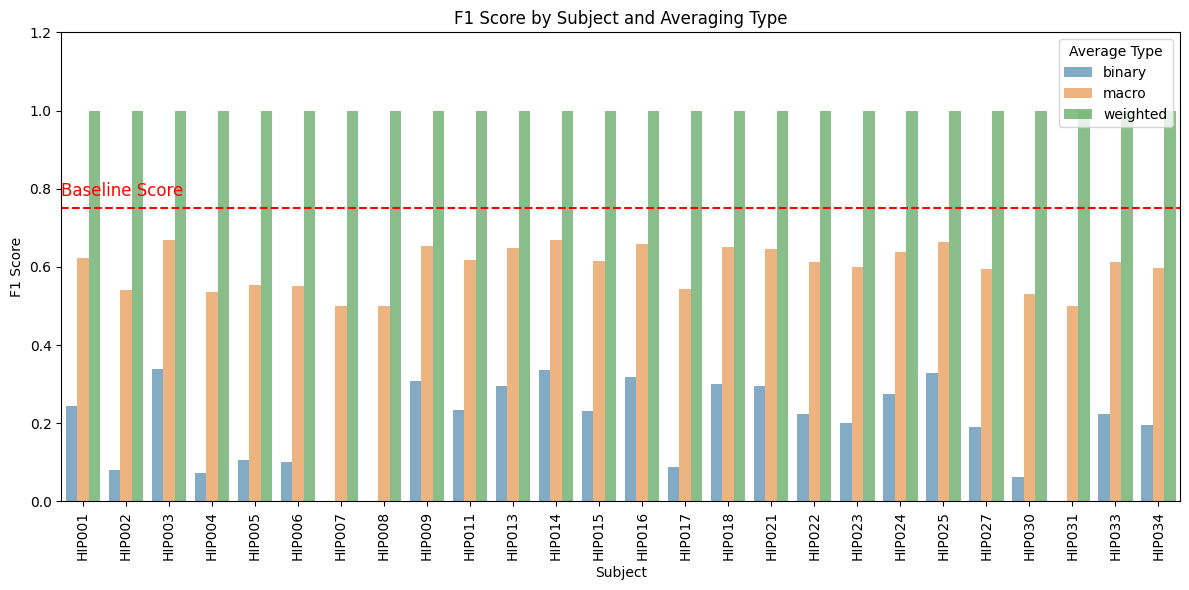

In [64]:
# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot the F1 scores with hue for average type
sns.barplot(
    x="Subject",
    y="F1 Score",
    hue="Average Type",
    data=f1_df,
    alpha=0.6,
)

# Add a legend and informative axis labels
plt.legend(ncol=1, loc="upper right", frameon=True, title="Average Type")
plt.ylabel("F1 Score")
plt.xlabel("Subject")
plt.title("F1 Score by Subject and Averaging Type")

# Set y-axis limits
plt.ylim(0, 1.2)

# Add horizontal lines at y = 0.75 with a label
plt.axhline(y=0.75, color="red", linestyle="--")
plt.text(-0.5, 0.77, "Baseline Score", color="red", fontsize=12, va="bottom")

# Rotate the x labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()